In [184]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from datetime import datetime, timedelta
import time
import matplotlib.pylab as plt
from datasets import Dataset,DatasetDict
from transformers import AutoModelForSequenceClassification,AutoTokenizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import pickle
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from scipy import stats as st
import tensorflow_hub as hub
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
   # for filename in filenames:
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [80]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

# Sentiment Analaysis of Reddit Posts to predict Bitcoin
*This was written by Joseph Hardin for my final in Introduction to Deep Learining*

Bitcoin is the most well known cryptocurrency in the world.  Cryptocurrencies, like all assests, are prone to price fluctuations due to speculation.  It is my belief that this speculation takes place in a more open and democratic way with cryptocurrency.  This speculation takes place in the open on major communication websites like Reddit and Twitter.  In this notebook I will try to look only at the sentiments of Reddit posts to see if I can predict the price of BTC for the next day.  Basically, is the 'mood' of a the main bitcoin subreddit predictive of the how the USD/BTC exchange rate changes the following day. This notebook is part two where I will use more advance machine learning techniques

# Import Reddit Data and Clean

Kaggle user **leukipp** pulls posts related to mutliple reddit cryptocurrency communities https://www.kaggle.com/datasets/leukipp/reddit-crypto-data  (THANK YOU!).  This is the source of my data, although the original is from Reddit.com/r/bitcoin.  I have spot checked several of the post and was able to verify they were indeed posted. It is updated daily so rerunning this notebook will change the data I have currently.

This is the second notebook.  The first used simpler unsupervised learning techinques.  In this notebook we will build a neural network that takes advantage of both the metadata and the stockprice.  Previously we only looked at sentiment analysis and used KNN search of the days that had the most similair sentiment.  This proved ineffective. 

In [81]:
file_path = "../input/reddit-crypto-data/bitcoin/submission.csv"

data = pd.read_csv(file_path)


In [82]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63228 entries, 0 to 63227
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   submission             63228 non-null  object 
 1   subreddit              63228 non-null  object 
 2   author                 63228 non-null  object 
 3   created                63228 non-null  int64  
 4   retrieved              63228 non-null  int64  
 5   edited                 63228 non-null  int64  
 6   pinned                 63228 non-null  int64  
 7   archived               63228 non-null  int64  
 8   locked                 63228 non-null  int64  
 9   removed                63228 non-null  int64  
 10  deleted                63228 non-null  int64  
 11  is_self                63228 non-null  int64  
 12  is_video               63228 non-null  int64  
 13  is_original_content    63228 non-null  int64  
 14  title                  63219 non-null  object 
 15  li

There are multiple columns and not all have data on every row.  The feature I am most interested is the content of the **selftext** which makes up a little more than half of the posts at first glance.  However even looking at the first 10 rows , we can see the string [removed] is used as a stand in for null-data.  To clean up this data we will:

1. Clarify 'created' by renaming it to 'date_created' and converting timestamp to human readable date (YYYY-MM-DD)
2. Keep meta data about text that informs how much the community engaged with the post (upvote ratio, score, total awards recieved , total number of comments)
3. Remove any posts that have less than 20 characters of text in the selftext feature
4. Drop the rest of the features 


In [83]:
data.head(10)

,submission,subreddit,author,created,retrieved,edited,pinned,archived,locked,removed,...,link_flair_text,upvote_ratio,score,gilded,total_awards_received,num_comments,num_crossposts,selftext,thumbnail,shortlink
0,rt6r1a,bitcoin,boom888boom,1640995385,1641140399,0,0,0,0,1,...,off topic,1.00,3,0,0,2,0,[removed],default,https://redd.it/rt6r1a
1,rt6s86,bitcoin,[deleted],1640995487,1641140399,0,0,0,1,1,...,altcoin,0.43,0,0,0,2,0,[removed],default,https://redd.it/rt6s86
2,rt6tub,bitcoin,FSdotorg,1640995629,1641140396,0,0,0,1,1,...,altcoin,0.33,0,0,0,2,0,[removed],default,https://redd.it/rt6tub
3,rt711v,bitcoin,Squigglywiggler,1640996258,1641140399,0,0,0,0,0,...,None,0.75,12,0,0,9,0,Anyone heard any news about this? Any opinions...,self,https://redd.it/rt711v
4,rt76mj,bitcoin,BuyTheDipper,1640996745,1641140399,0,0,0,0,1,...,repetitive,0.75,2,0,0,4,0,[removed],default,https://redd.it/rt76mj
5,rt7c2v,bitcoin,Rose-Ariana,1640997244,1641140399,0,0,0,0,1,...,None,1.00,1,0,0,0,0,NaN,default,https://redd.it/rt7c2v
6,rt7qa5,bitcoin,SilverAndAlgorand,1640998555,1641140399,0,0,0,0,0,...,None,0.86,1176,0,21,510,2,I only have .03 btc but I still feel early as ...,self,https://redd.it/rt7qa5
7,rt7x3t,bitcoin,Geoknysis,1640999166,1641140399,0,0,0,0,0,...,None,0.75,2,0,0,10,0,"Okay,\n\nSo I want to move away from Exodus an...",self,https://redd.it/rt7x3t
8,rt7ymo,bitcoin,GlassDazzling5438,1640999308,1641140399,0,0,0,0,1,...,low quality,0.32,0,0,0,10,0,[removed],default,https://redd.it/rt7ymo
9,rt86pj,bitcoin,Mannycass,1641000037,1641140399,0,0,0,0,0,...,None,0.80,6,0,0,6,0,https://www.ivey.uwo.ca/faculty/directory/geor...,self,https://redd.it/rt86pj


In [84]:
data['date_created'] = (data['created']).apply(lambda x: datetime.fromtimestamp(x).date())
columns_to_keep = ["date_created", "upvote_ratio", "score", "total_awards_received", "num_comments", "selftext"]

columns_to_delete = list(data.columns.values)

for keep in columns_to_keep:
    #print(keep)
    columns_to_delete.remove(keep)
data.drop(columns_to_delete, axis = 1,inplace = True)
data = data[data ['selftext'].str.len() >= 20]
data.head(10)



,upvote_ratio,score,total_awards_received,num_comments,selftext,date_created
3,0.75,12,0,9,Anyone heard any news about this? Any opinions...,2022-01-01
6,0.86,1176,21,510,I only have .03 btc but I still feel early as ...,2022-01-01
7,0.75,2,0,10,"Okay,\n\nSo I want to move away from Exodus an...",2022-01-01
9,0.80,6,0,6,https://www.ivey.uwo.ca/faculty/directory/geor...,2022-01-01
23,0.36,0,0,11,"Just a genuine question, I’ve googled biggest ...",2022-01-01
32,0.60,2,0,17,If people see the value going up then why is i...,2022-01-01
38,0.60,1,0,5,\nHappy New Year!! \n\nI have a burning questi...,2022-01-01
40,0.96,60,0,604,Please utilize this sticky thread for all gene...,2022-01-01
43,0.61,13,0,49,"Thank god it is on sale, idk that I could take...",2022-01-01
47,0.50,0,0,26,"I bought $1,000 AUD in BTC on 29th Jan 2021.\n...",2022-01-01


There is one more major data cleaning task for these reddit posts before moving on to bitcoin prices.  Everyday there is an automatic post for Bitcoin discussions.  None of the data collected here is the context of comments, however the metadata from this post is extremely interesting. Because the user (a bot) and the text is the  same everytime, the differences in engagement everyday *could* be generalized to the level of engagement with BTC overtime.  However, we do not want the daily posts to affect our word counts so it will be deleted.  The full context of the selftext can be seen below. 

In [85]:
sticky_message = "Please utilize this sticky thread for"

sticky_df = data[data.selftext.str.startswith(sticky_message)]
data[data['selftext'].str.contains(sticky_message).fillna(False)] = None
data.dropna(axis = 0, inplace = True)
print(sticky_df.selftext.iloc[0])

Please utilize this sticky thread for all general **Bitcoin** discussions! If you see posts on the front page or /r/Bitcoin/new which are better suited for this daily discussion thread, please help out by directing the OP to this thread instead. Thank you!

If you don't get an answer to your question, you can try phrasing it differently or commenting again tomorrow.

[Join us in the r/Bitcoin Chatroom!](https://discord.gg/K5H25KZHke)

Please check the [previous discussion thread](https://www.reddit.com/r/Bitcoin/comments/rsm1x9/daily_discussion_december_31_2021/) for unanswered questions.


In [97]:
sticky_df.head(10)

,upvote_ratio,score,total_awards_received,num_comments,selftext,date_created
40,0.96,60,0,604,Please utilize this sticky thread for all gene...,2022-01-01
209,0.93,34,0,103,Please utilize this sticky thread for all gene...,2022-01-02
402,0.90,41,0,258,Please utilize this sticky thread for all gene...,2022-01-03
648,0.88,34,0,182,Please utilize this sticky thread for all gene...,2022-01-04
881,0.89,33,0,241,Please utilize this sticky thread for all gene...,2022-01-05
1164,0.92,55,1,464,Please utilize this sticky thread for all gene...,2022-01-06
1518,0.95,65,1,598,Please utilize this sticky thread for all gene...,2022-01-07
1803,0.87,34,1,252,Please utilize this sticky thread for all gene...,2022-01-08
2075,0.98,40,0,218,Please utilize this sticky thread for all gene...,2022-01-09
2305,0.91,41,0,354,Please utilize this sticky thread for all gene...,2022-01-10


In [284]:


max_num_posts = st.mode(data.date_created)[1][0]
num_days = len(data.date_created.unique())
df_dates = pd.DataFrame({'date': data.date_created.unique()})
ls_text = [" "] * num_days



ds_meta = np.zeros(shape = (num_days,max_num_posts,4))  # Array for meta data related to posts
ds_sticky = np.zeros(shape = (num_days,4))
for date, d in zip(data.date_created.unique(), np.arange(num_days)):
    temp_df = data[data.date_created == date]
    try:
        ds_sticky[d] =  sticky_df[sticky_df.date_created == date].upvote_ratio.values[0],
        sticky_df[sticky_df.date_created == date].score.values[0],
        sticky_df[sticky_df.date_created == date].total_awards_received.values[0], 
        sticky_df[sticky_df.date_created == date].num_comments.values[0]
        #print(temp_df)
    except:
        print("Day ", date, " is probably missing from stickied post")
    
    for row in range(len(temp_df.index)):#, np.arange(len(data[data.date_created == date]))):
      #  print(temp_df.iloc[row].selftext)
        ls_text[d] = ls_text[d] + " " + str(temp_df.iloc[row].selftext)
        ds_meta[d][row] = temp_df.iloc[row].upvote_ratio,temp_df.iloc[row].score, temp_df.iloc[row].total_awards_received, temp_df.iloc[row].num_comments 
        
        

Day  2022-02-06  is probably missing from stickied post


In [ ]:
data.to_pickle("/kaggle/working/data.pkl")  
data = pd.read_pickle("/kaggle/working/data.pkl")

# Import Prices , Clean Data, and Transform

A Kaggle User SRK (THANK YOU!) uses CoinGecko to pull cryptocurrency price information  https://www.kaggle.com/datasets/sudalairajkumar/cryptocurrency-historical-prices-coingecko/versions/57  It is from here that the USD/BTC price infromation is captured.  Although the total_volume information could be useful, the only thing I am interested in is the price of the coin and the date. 

1. Drop all information but price and date
2. Drop time from timedate format as it is too granualar 
3. Focus only on 2022 because that is the same timeframe as the Reddit Data 
4. Calculate the percent change from the current day to the next "x" day

    a. The Days forecasted are 1,3,5,7,10 days into the 'future'  
    
    b. If the forecast is a percent increase a '1' is assigned to that days binary column.  '0' is for no change or negative.  
    
    c. For Example if the price goes from 100 on day 0 to 90 on day 1, day 1 forecast will be -0.1 to represent the drop by 10 percent and day 1b forecast will be 0



In [139]:
prices = pd.read_csv('../input/cryptocurrency-historical-prices-coingecko/bitcoin.csv')
prices.head(10)

,date,price,total_volume,market_cap,coin_name
0,2015-01-01 00:00:00.000,313.9920,4.699936e+07,4.293958e+09,bitcoin
1,2015-01-02 00:00:00.000,314.4460,3.885591e+07,4.301448e+09,bitcoin
2,2015-01-03 00:00:00.000,286.5720,1.187789e+08,3.921358e+09,bitcoin
3,2015-01-04 00:00:00.000,260.9360,2.055001e+08,3.571640e+09,bitcoin
4,2015-01-05 00:00:00.000,273.2200,1.550381e+08,3.740880e+09,bitcoin
5,2015-01-06 00:00:00.000,285.3738,9.700290e+07,3.908408e+09,bitcoin
6,2015-01-07 00:00:00.000,295.8725,1.106742e+08,4.053239e+09,bitcoin
7,2015-01-08 00:00:00.000,284.4525,8.657054e+07,3.897824e+09,bitcoin
8,2015-01-09 00:00:00.000,289.5738,8.347840e+07,3.968993e+09,bitcoin
9,2015-01-10 00:00:00.000,274.5330,9.268384e+07,3.763909e+09,bitcoin


In [140]:

def add_price_forecast(prices, forecast_days):
    col_names = prices.columns
    # First Start fresh by deleting any previous forecast data"
    end_date = max(prices['date'])
    print(col_names)
    for col in col_names:
        if col.startswith("forecast"):
            prices.drop(col, axis = 1, inplace = True)
    
    for day in forecast_days:
        prices["forecast_" + str(day)] = 0
        prices["forecast_" + str(day) +"b"] = 0  #b for binary
    
   
    for i in prices.index:
        for days in forecast_days:
            stop_date = i +  days
            
            
            if stop_date < len(prices):
                try:
                    prices.loc[i, "forecast_" + str(days)] = (prices.loc[stop_date,'price'] - prices.loc[i,'price']) / prices.loc[i,'price']
                    if prices.loc[i, "forecast_" + str(days)] > 0:
                        prices.loc[i,"forecast_" + str(days) +"b"] = 1
                except Exception as e:
                    None
                    print(e)
                
        
    
    return prices






try:
    prices['date'] = (prices['date']).apply(lambda x: datetime.fromisoformat(x).date())
except Exception as e:
    print(e)
try:
    prices.drop(['total_volume', 'market_cap', 'coin_name'] ,axis = 1, inplace = True)
    
except:
    None
prices.head(10)
forecast_days = [1,3,5,7,10]



In [141]:
prices = add_price_forecast(prices, forecast_days)
print("Price Data ranges from " , min(prices['date']), " to " , (max(prices['date'])))
print("Reddit Data ranges from " , min(data['date_created']), " to " , (max(data['date_created'])))
prices = prices[prices['date'] >= min(data['date_created'])]
print("New Price Data ranges from " , min(prices['date']), " to " , (max(prices['date'])))

prices.head(10)


Index(['date', 'price'], dtype='object')
Price Data ranges from  2015-01-01  to  2022-12-03
Reddit Data ranges from  2022-01-01  to  2022-12-03
New Price Data ranges from  2022-01-01  to  2022-12-03


,date,price,forecast_1,forecast_1b,forecast_3,forecast_3b,forecast_5,forecast_5b,forecast_7,forecast_7b,forecast_10,forecast_10b
2556,2022-01-01,46319.651088,0.032307,1,0.004566,1,-0.057697,0,-0.103465,0,-0.096067,0
2557,2022-01-02,47816.077676,-0.008969,0,-0.039277,0,-0.096194,0,-0.126723,0,-0.105380,0
2558,2022-01-03,47387.212168,-0.018065,0,-0.078926,0,-0.123662,0,-0.116589,0,-0.071862,0
2559,2022-01-04,46531.140861,-0.012747,0,-0.071236,0,-0.102608,0,-0.100176,0,-0.084303,0
2560,2022-01-05,45938.024272,-0.049869,0,-0.096017,0,-0.088721,0,-0.068806,0,-0.061325,0
2561,2022-01-06,43647.147508,-0.009868,0,-0.043313,0,-0.040719,0,0.007669,1,-0.009634,0
2562,2022-01-07,43216.458677,-0.039088,0,-0.031333,0,-0.010164,0,-0.014070,0,-0.002237,0
2563,2022-01-08,41527.197043,0.005526,1,0.008252,1,0.059110,1,0.038376,1,0.018570,1
2564,2022-01-09,41756.662324,0.002531,1,0.024440,1,0.020398,1,0.035204,1,0.015298,1
2565,2022-01-10,41862.360986,0.000179,1,0.050631,1,0.030063,1,0.030037,1,-0.002695,0


In [96]:
prices.to_pickle("/kaggle/working/prices.pkl")  
prices = pd.read_pickle("/kaggle/working/prices.pkl")

Bitcoin has not had the best year.  This graph is even a little worse than it looks because the USD is experiencing high inflation

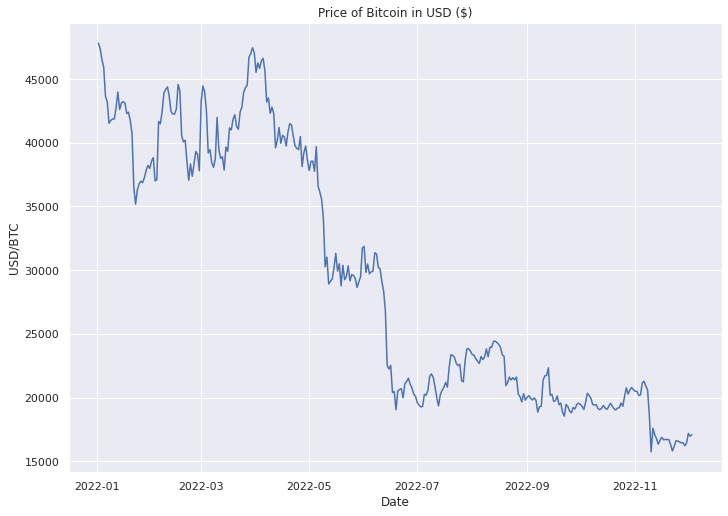

In [98]:
ax = sns.lineplot(x = prices['date'], y = prices['price'])
ax.set(title = "Price of Bitcoin in USD ($)", ylabel = 'USD/BTC', xlabel = "Date")
plt.show()

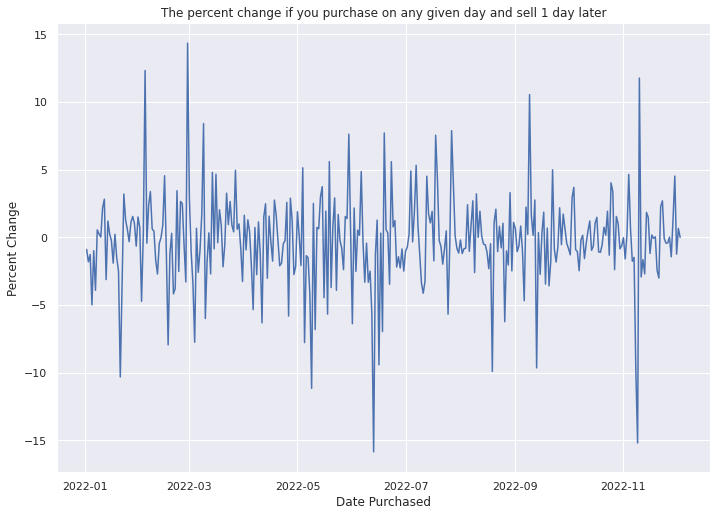

In [99]:
ax = sns.lineplot(x = prices['date'], y = prices['forecast_1']*100)
ax.set(title = "The percent change if you purchase on any given day and sell 1 day later", ylabel = 'Percent Change', xlabel = "Date Purchased")
plt.show()

Even though BTC has had a rough year, there are just slightly more days where the price of bitcoin goes down (0) than when it goes up (1).  That means that there is still money to be made if we can properly time these fluctuations

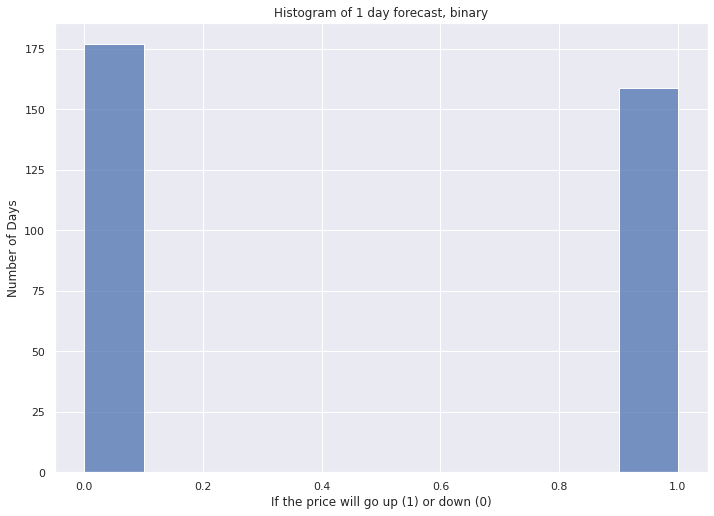

In [100]:
ax = sns.histplot(prices['forecast_1b'])
ax.set(xlabel = "If the price will go up (1) or down (0)", ylabel = 'Number of Days', title = "Histogram of 1 day forecast, binary")
plt.show()

In [285]:

td = int(.1 * len(df_dates))
rand_ind = df_dates.sample(frac = 1).index
print(rand_ind)
test_dates =  [val for (_, val) in sorted(zip(rand_ind, df_dates.date), key=lambda x: x[0])][:td]
train_dates = [val for (_, val) in sorted(zip(rand_ind, df_dates.date), key=lambda x: x[0])][td:]

test_text = np.array([val for (_, val) in sorted(zip(rand_ind, ls_text), key=lambda x: x[0])][:td])
train_text = np.array([val for (_, val) in sorted(zip(rand_ind, ls_text), key=lambda x: x[0])][td:])

test_meta = np.array([val for (_, val) in sorted(zip(rand_ind, ds_meta), key=lambda x: x[0])][:td])
train_meta = np.array([val for (_, val) in sorted(zip(rand_ind, ds_meta), key=lambda x: x[0])][td:])

test_sticky =  np.array([val for (_, val) in sorted(zip(rand_ind, ds_sticky), key=lambda x: x[0])][:td])
train_sticky = np.array([val for (_, val) in sorted(zip(rand_ind, ds_sticky), key=lambda x: x[0])][td:])

test_y =  np.array([val for (_, val) in sorted(zip(rand_ind, prices.forecast_1), key=lambda x: x[0])][:td])
train_y = np.array([val for (_, val) in sorted(zip(rand_ind, prices.forecast_1), key=lambda x: x[0])][td:] )




Int64Index([ 35, 237, 293,  78, 223, 292, 132, 144,  92,  49,
            ...
            296, 277, 155, 189, 225,  65, 201, 303, 107,  11],
           dtype='int64', length=337)


In [273]:
print(ds_sticky)

(array([0.83]), array([26]), array([0]), array([86]))


# Building Models

Below are the archetictures for simple multi-input regression models for predicting price

In [339]:



text_input = keras.Input( shape = (),  dtype= tf.string, name = "Self Text " )

sticky_input = keras.Input(shape = (4,), dtype = tf.float64, name =  "Daily Stickied Post Metadata")

meta_input = keras.Input(shape = (max_num_posts, 4,), dtype = tf.float64, name =  "Post Metadata")

fl_input = layers.Flatten()(sticky_input)

f2_input = layers.Flatten()(meta_input)

embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding, input_shape=[], dtype=tf.string, trainable=True)(text_input)


dense_layer1 = tf.keras.layers.Dense(16, activation='linear')(hub_layer)
text_guess = layers.Dense(1, name="textguess")(dense_layer1)



dense_layer2 = tf.keras.layers.Dense(32, activation='linear')(fl_input)
dense_layer3 = tf.keras.layers.Dense(8, activation='linear')(dense_layer2)
dense_layer4 = tf.keras.layers.Dense(4, activation='linear')(dense_layer3)
sticky_guess = layers.Dense(1, name="stickiedguess")(dense_layer4)


dense_layer5 = tf.keras.layers.Dense(64, activation='linear')(f2_input)
dense_layer6 = tf.keras.layers.Dense(32, activation='linear')(dense_layer5)
dense_layer7 = tf.keras.layers.Dense(16, activation='linear')(dense_layer6)
dense_layer8 = tf.keras.layers.Dense(8, activation='linear')(dense_layer7)
dense_layer9 = tf.keras.layers.Dense(4, activation='linear')(dense_layer8)
meta_guess = layers.Dense(1, name="metaguess")(dense_layer9)

# Stick a logistic regression for priority prediction on top of the features


y_hat = layers.Average()( [sticky_guess, meta_guess, text_guess])


model = keras.Model(
    inputs= [text_input, meta_input, sticky_input], 
    outputs=y_hat
)

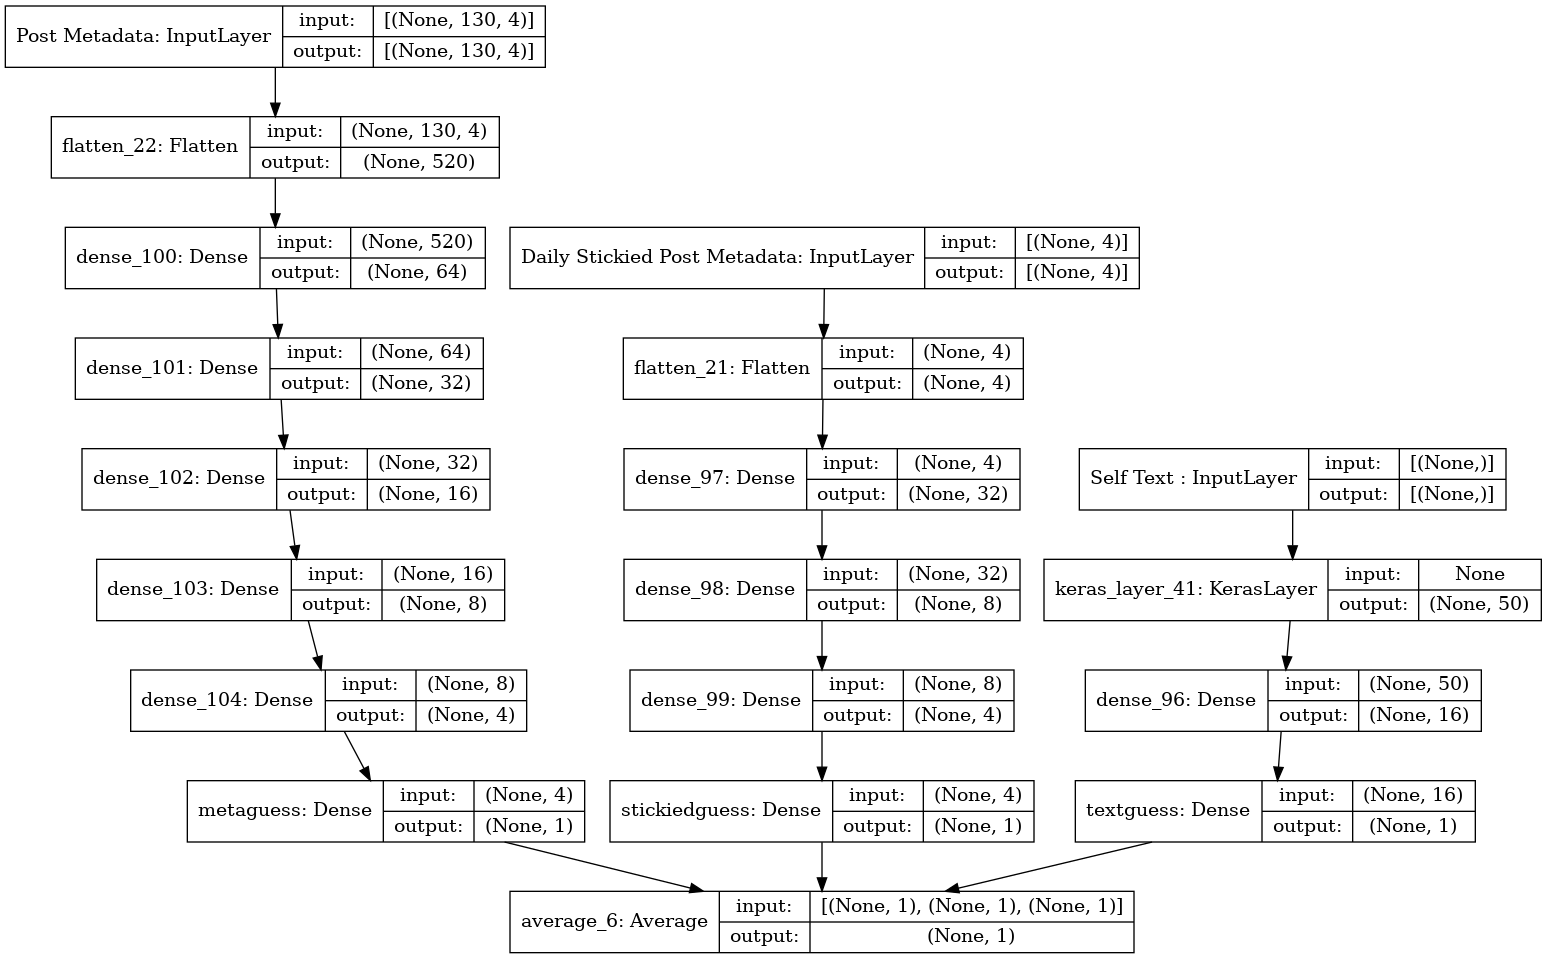

In [340]:
keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

In [341]:
model.compile(optimizer='sgd',
              loss=tf.keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error"),
              metrics=['mse'])


In [342]:


history  = model.fit( x = [train_text,train_meta, train_sticky], y = train_y, batch_size = 10,  epochs=20, validation_split=0.2)

Epoch 1/20
25/25 [==============================] - 3s 92ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 2/20
25/25 [==============================] - 2s 77ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 3/20
25/25 [==============================] - 2s 77ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 4/20
25/25 [==============================] - 2s 77ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 5/20
25/25 [==============================] - 2s 77ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 6/20
25/25 [==============================] - 2s 77ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 7/20
25/25 [==============================] - 2s 81ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 8/20
25/25 [==============================] - 2s 76ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 9/20
25/25 [==============================

In [347]:



text_input = keras.Input( shape = (),  dtype= tf.string, name = "Self Text " )

sticky_input = keras.Input(shape = (4,), dtype = tf.float64, name =  "Daily Stickied Post Metadata")

meta_input = keras.Input(shape = (max_num_posts, 4,), dtype = tf.float64, name =  "Post Metadata")

fl_input = layers.Flatten()(sticky_input)

f2_input = layers.Flatten()(meta_input)

embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding, input_shape=[], dtype=tf.string, trainable=True)(text_input)


dense_layer1 = tf.keras.layers.Dense(16, activation='linear')(hub_layer)
text_guess = layers.Dense(1, name="textguess")(dense_layer1)



dense_layer2 = tf.keras.layers.Dense(32, activation='linear')(fl_input)
dense_layer3 = tf.keras.layers.Dense(8, activation='linear')(dense_layer2)
dense_layer4 = tf.keras.layers.Dense(4, activation='linear')(dense_layer3)
sticky_guess = layers.Dense(1, name="stickiedguess")(dense_layer4)


dense_layer5 = tf.keras.layers.Dense(64, activation='linear')(f2_input)
dense_layer6 = tf.keras.layers.Dense(32, activation='linear')(dense_layer5)
dense_layer7 = tf.keras.layers.Dense(16, activation='linear')(dense_layer6)
dense_layer8 = tf.keras.layers.Dense(8, activation='linear')(dense_layer7)
dense_layer9 = tf.keras.layers.Dense(4, activation='linear')(dense_layer8)
meta_guess = layers.Dense(1, name="metaguess")(dense_layer9)

# Stick a logistic regression for priority prediction on top of the features


y_hat = layers.Average()( [sticky_guess,  text_guess])


model1 = keras.Model(
    inputs= [text_input, meta_input, sticky_input], 
    outputs=y_hat
)

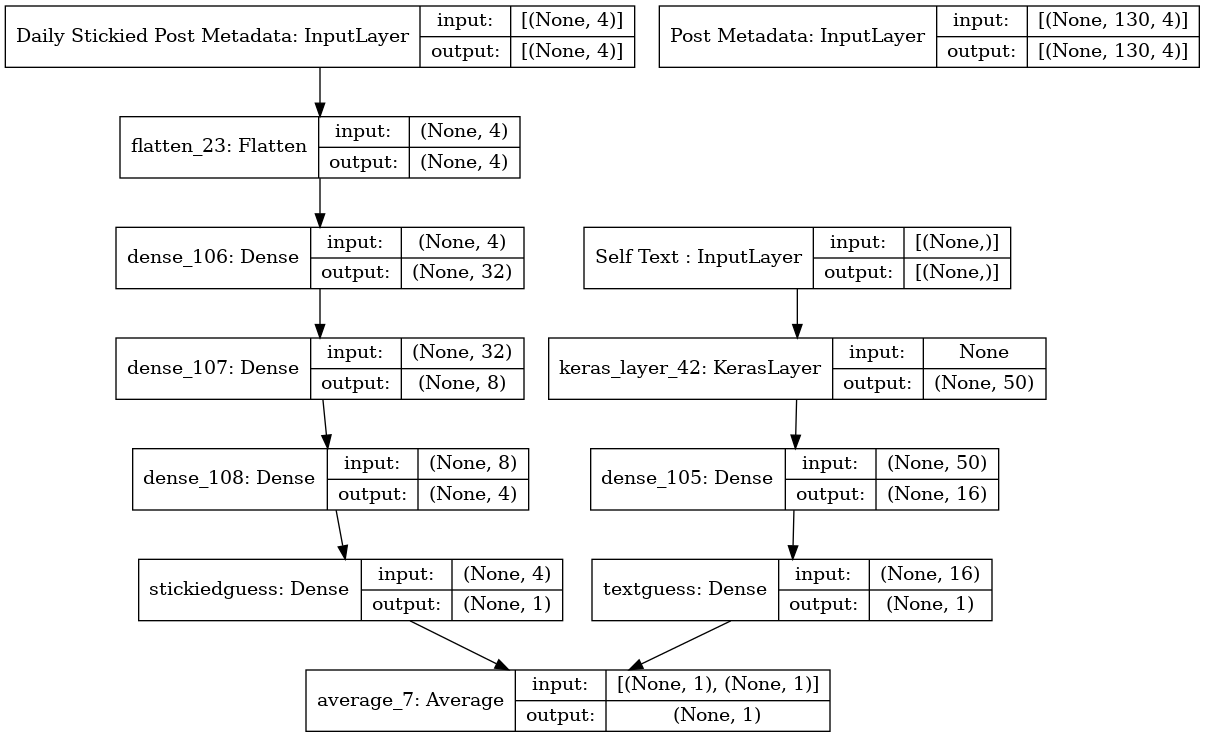

In [348]:
keras.utils.plot_model(model1, "multi_input_and_output_model.png", show_shapes=True)

In [349]:
model1.compile(optimizer='sgd',
              loss=tf.keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error"),
              metrics=['mse'])
history1  = model1.fit( x = [train_text,train_meta, train_sticky], y = train_y, batch_size = 10,  epochs=20, validation_split=0.2)

Epoch 1/20
25/25 [==============================] - 3s 89ms/step - loss: 0.0981 - mse: 0.0981 - val_loss: 0.0334 - val_mse: 0.0334
Epoch 2/20
25/25 [==============================] - 2s 76ms/step - loss: 0.0250 - mse: 0.0250 - val_loss: 0.0253 - val_mse: 0.0253
Epoch 3/20
25/25 [==============================] - 2s 76ms/step - loss: 0.0214 - mse: 0.0214 - val_loss: 0.0203 - val_mse: 0.0203
Epoch 4/20
25/25 [==============================] - 2s 76ms/step - loss: 0.0257 - mse: 0.0257 - val_loss: 0.0169 - val_mse: 0.0169
Epoch 5/20
25/25 [==============================] - 2s 77ms/step - loss: 0.0210 - mse: 0.0210 - val_loss: 0.0188 - val_mse: 0.0188
Epoch 6/20
25/25 [==============================] - 2s 79ms/step - loss: 0.0169 - mse: 0.0169 - val_loss: 0.0168 - val_mse: 0.0168
Epoch 7/20
25/25 [==============================] - 2s 77ms/step - loss: 0.0161 - mse: 0.0161 - val_loss: 0.0128 - val_mse: 0.0128
Epoch 8/20
25/25 [==============================] - 2s 77ms/step - loss: 0.0171 - m

In [351]:
history_dict = history1.history
history_dict.keys()

dict_keys(['loss', 'mse', 'val_loss', 'val_mse'])

# Results

We were able to find a model that did coverege, however it is imporatnt to realize when looking at the mean square error that there is no normailization in that paramater.  Put another way, the deltas we are attempting to predict are pretty small falling between +/- 0.2 so even a poor model will have a number 'close' to 0

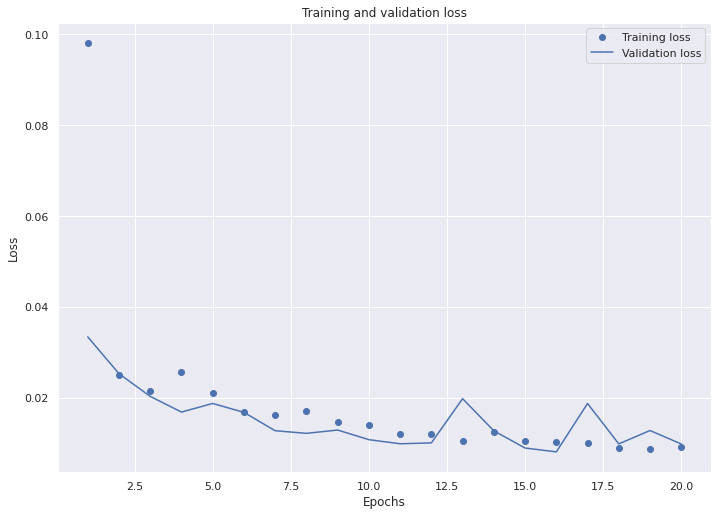

In [352]:
mse = history_dict['mse']
val_mse = history_dict['val_mse']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(mse) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

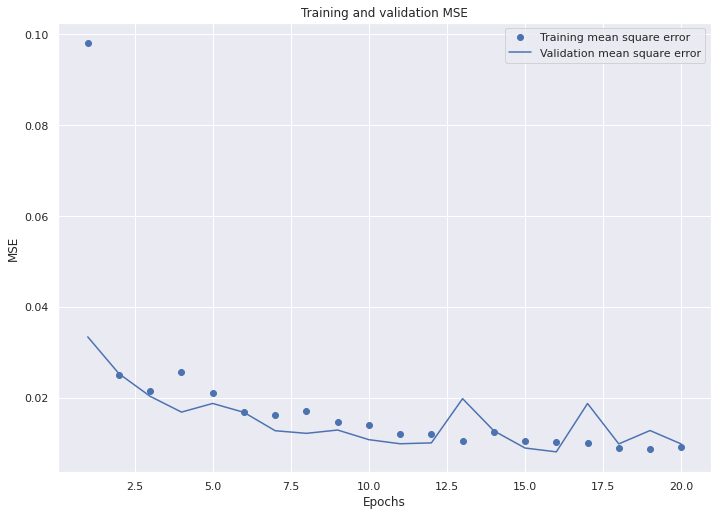

In [354]:
plt.plot(epochs, mse, 'bo', label='Training mean square error')
plt.plot(epochs, val_mse, 'b', label='Validation mean square error')
plt.title('Training and validation MSE')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend(loc='upper right')

plt.show()

In [357]:
answer = model1.predict(x=[test_text,test_meta, test_sticky])

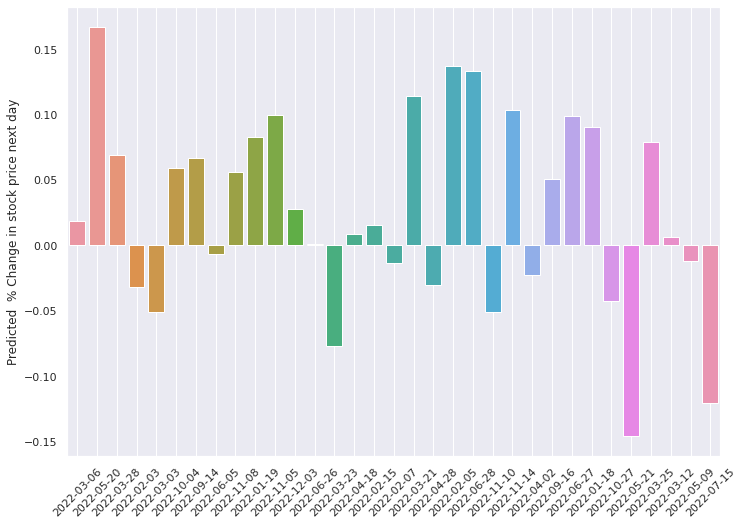

In [375]:
sns.barplot(x = test_dates, y = answer[:,0]) 
plt.xticks(rotation=45)
plt.ylabel("Predicted  % Change in stock price next day")
plt.grid()

None

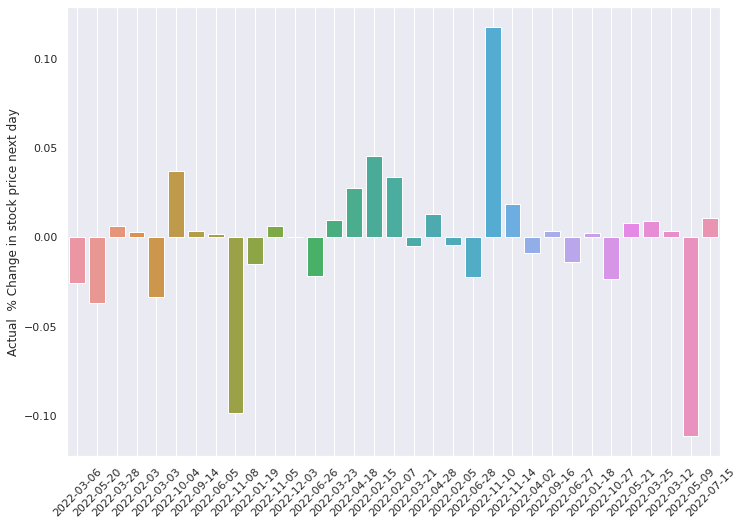

In [376]:
sns.barplot(x = test_dates, y = test_y) 
plt.ylabel("Actual  % Change in stock price next day")
plt.xticks(rotation=45)
plt.grid()
None

The graph below is the only one that really 'matters'.  Because the dates are randomly chosen, I can't explain in detail the graph that you are looking at, but what should be clear is that a perfect model wouldn't have any bars (they would all be 0).  The larger the magnitude of the bar the larger the error on that day.

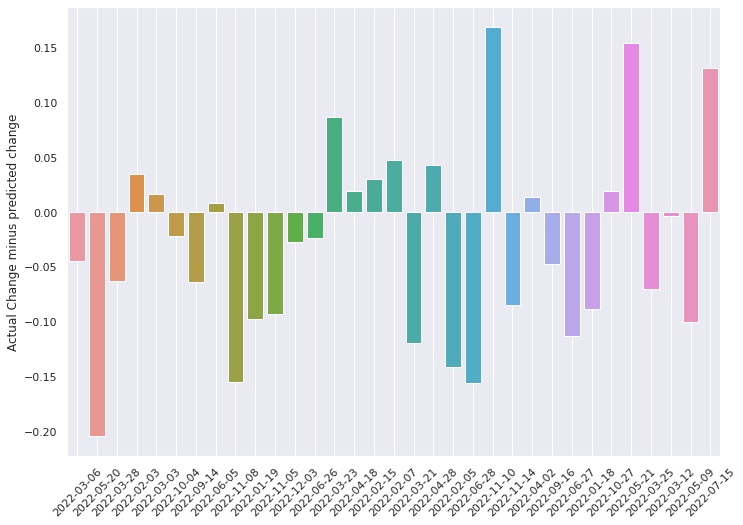

In [378]:
delta = test_y - answer[:,0]
sns.barplot(x = test_dates, y = delta )
plt.xticks(rotation=45)
plt.ylabel("Actual Change minus predicted change")
plt.grid()
None

# Conclusion
Although I was able to use more robust methodologies, this model still would not allow a user to 'daytrade' with bitcoin.  I was unable to get a model to converge when attempting regression nueral network that incorparated the metadata from reddit post.  One of the reasons could be that I decided to use the max post ever in a day, and then pad the remaining days with zero.  Perhaps a better approach in the future would be to only take the top n (10,50, ?) post's metadata.  Additionally, the meta data per post was divorced from the actual text that was post.  This seems like a likely source of error.  Because this is a 'real-world' problem without a predifined solition,  it is not possible at this time to conclude that my hypothesis -- Reddit behavior on /r/bitcoin is a short term predictor of Bitcoin price fluctuations -- is incorrect or if my methodology is simply flawed.  The only thing that can be reasonbly concluded is I shouldn't be your money manager if I plan to use this algorithim.  